# 第5章 誤差伝播法

### 重みパラメータの勾配計算方法を効率良く行う方法の一つである「誤差伝播法」について学ぶ。

## 5.4節　単純なレイヤの実装

#### 計算グラフの乗算ノードを「乗算レイヤ」、加算ノードを「加算レイヤ」として実装する。

* ## 加算レイヤ
#### 左からきた入力信号を次のノードに出力するだけ。

<img src='./figures/AddLayer.jpg'>

In [44]:
# 加算レイヤ
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y
        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

* ## 乗算レイヤ

#### ひっくり返してかけた値を返す

<img src='./figures/MultipleLayer.jpg'>

In [46]:
# 乗算レイヤ
class MulLayer:
    # 逆伝播のためにクラス自体に入力値を保持させる必要がある
    def __init__(self):
        self.x = None
        self.y = None

    # 順伝播
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        return out

    # 逆伝播
    def backward(self, dout):
        dx = dout * self.y # xとyをひっくり返す
        dy = dout * self.x
        return dx, dy

* ## 例 : 消費税のかかるりんご2個とみかん3個の買い物

<img src='./figures/Apple-and-Orange.jpeg'>

In [58]:
# 例）消費税がかかるりんご2個とみかん3個の買い物

apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1 # 消費税は10%

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(price)

715.0000000000001


In [66]:
print(dapple_num, dapple, dorange_num, dorange,dtax)

110.00000000000001 2.2 165.0 3.3000000000000003 650


#### 左から順に、「りんごが一個増えた時、合計価格は110円増加する」「りんごの値段が1円上がった時、合計価格は2.2円増加する」「オレンジの個数が1個増えた時、合計価格は165円増加する」「オレンジの価格が1円上がった時、合計価格は3.3円増加する」「税率が1.0上がった時（100%上がった時）、合計価格は650円変化する」ことを示す。<br>全て合計価格（L）に対する微分を表す文になっているのがわかるだろうか・・・・

# 5.5 活性化関数レイヤの実装

* ## ReLUレイヤ

In [72]:
# ReLUレイヤ
class Relu:
    def __init__(self):
        self.mask = None # TrueとFalseからなるnumpy配列

    # xは値が何個か入った配列がやってくることを想定
    def forward(self, x):
        # xの値が0以下の場所をTrue、それ以外をFalseに設定
        self.mask = (x <= 0) 
        out = x.copy()
        # self.maskの値がTrueの部分を0に設定
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx
        

* ## Sigmoidレイヤ

<img src='./figures/SigmoidLayer.jpeg'>

最後の出力結果を少し書き換えると出力値$y$のみを含む形で書くことができて、

$$ \frac{\partial L}{\partial y} y (1 - y)$$

がシグモイドレイヤの逆伝播になる。

In [85]:
import numpy as np
# Sigmoidレイヤ
class Sigmoid:
    def __init__(self):
        selt.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

* # 5.6 Affine / Softmaxレイヤの実装

* ## Affineレイヤ

#### 行列計算$$ Y = X \cdot W + B$$を行うレイヤを「Affineレイヤ」と呼ぶ。<br>それぞれの行列の形状に注意すること。

In [134]:
# Affineレイヤ
# 計算の詳細は省略
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        return dx

* ## Softmax-with-Lossレイヤ

損失関数である交差エントロピー誤差も含めて一つのレイヤとして実装する。

In [122]:
# ソフトマックスレイヤ + 交差エントロピーレイヤ
from common.functions import *
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 損失
        self.y = None # softmaxの出力
        self.t = None # 教師データ(One-Hot Vector)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

* # 誤差逆伝播法に対応したニューラルネットワークの実装

In [138]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.functions import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:

    # input_size : 入力層のニューロンの数, hidden_size : 隠れ層のニューロンの数, output_size : 出力層のニューロンの数
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        # 一層目
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        # 二層目
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    # 損失関数。 x : 入力データ、t : 教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    # 正解率を出す
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 入力データ、 t : 教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W : self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

* ## 勾配確認の実装

### 勾配確認とは？
#### 実装が簡単な数値微分で計算した勾配の結果と誤差逆伝播法で実装した勾配の結果を比較して正しい実装ができているか確かめること。

In [140]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size = 784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 各重みの絶対誤差の平均を求める
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ':' + str(diff))

W1:4.4805901478141003e-10
b1:3.043519234728013e-09
W2:5.56403056874147e-09
b2:1.3878321564048112e-07


* ## 誤差伝播法を用いた学習の実装

In [147]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# ハイパーパラメータ
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iters_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 誤差伝播法によって勾配を求める
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]


    # 学習経過の記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    if i % iters_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('train accuracy, test accuracy | ' + str(train_acc) + ', ' + str(test_acc))

train accuracy, test accuracy | 0.153, 0.1581
train accuracy, test accuracy | 0.907, 0.9091
train accuracy, test accuracy | 0.9222833333333333, 0.9247
train accuracy, test accuracy | 0.9353833333333333, 0.9351
train accuracy, test accuracy | 0.94445, 0.9407
train accuracy, test accuracy | 0.9501833333333334, 0.945
train accuracy, test accuracy | 0.95545, 0.9504
train accuracy, test accuracy | 0.95995, 0.9541
train accuracy, test accuracy | 0.962, 0.9554
train accuracy, test accuracy | 0.9676, 0.9589
train accuracy, test accuracy | 0.9700833333333333, 0.9614
train accuracy, test accuracy | 0.9723333333333334, 0.9634
train accuracy, test accuracy | 0.9727, 0.9662
train accuracy, test accuracy | 0.9740333333333333, 0.9652
train accuracy, test accuracy | 0.9769166666666667, 0.9679
train accuracy, test accuracy | 0.9787333333333333, 0.9691
train accuracy, test accuracy | 0.9791, 0.9685


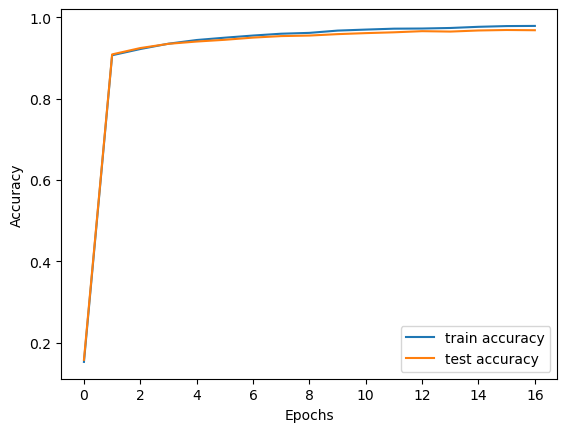

In [151]:
import matplotlib.pyplot as plt

plt.plot(train_acc_list, label='train accuracy')
plt.plot(test_acc_list, label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()